<a href="https://colab.research.google.com/github/JanMarcelKezmann/Boston-House-Prices/blob/master/Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
print(os.listdir())

['.config', 'sample_submission.csv', 'train.csv', 'test.csv', 'sample_data']


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [0]:
# get data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")
print("train.csv shape: " + str(train.shape))
print("test.csv shape: " + str(test.shape))
print("sample.csv shape: " + str(sample.shape))

train.csv shape: (1460, 81)
test.csv shape: (1459, 80)
sample.csv shape: (1459, 2)


In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

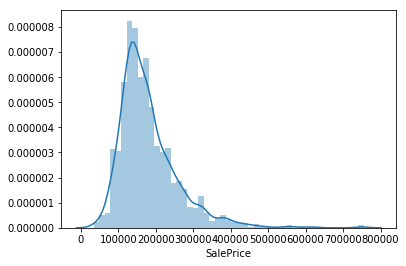

In [0]:
# get a overview of the SalePrice distribution
sns.distplot(train.SalePrice);

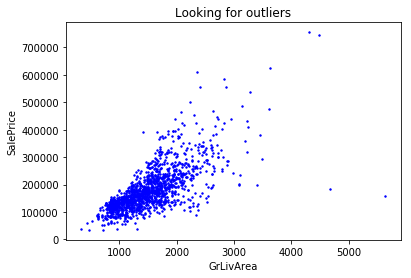

In [0]:
# look at some general outliers
plt.scatter(train.GrLivArea, train.SalePrice, c="blue", s=2)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [0]:
# remove outliers, i.e. GrLivArea > 4000
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

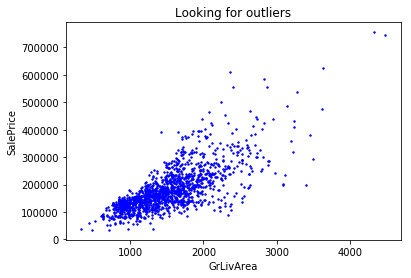

In [0]:
plt.scatter(train.GrLivArea, train.SalePrice, c="blue", s=2);
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [0]:
# log transform the SalePrice, so that the bigger values does not have a to big impact
# on the smaller ones
#train = train.drop(train.loc[train.Electrical.isnull()].index)
# save the "Id" column
train_ID = train["Id"]
test_ID = test["Id"]

# drop the "Id" column
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

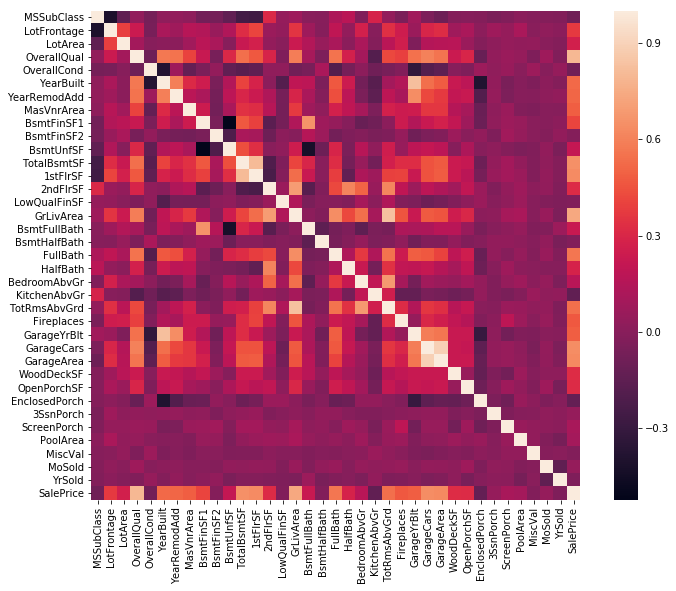

In [0]:
# build a correlation matrix to get an idea of the important or relevant categories
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True);

           index     value
0      SalePrice  1.000000
1    OverallQual  0.795774
2      GrLivArea  0.734968
3    TotalBsmtSF  0.651153
4     GarageCars  0.641047
5       1stFlrSF  0.631530
6     GarageArea  0.629217
7       FullBath  0.562165
8   TotRmsAbvGrd  0.537769
9      YearBuilt  0.523608
10  YearRemodAdd  0.507717
11   GarageYrBlt  0.487156
12    MasVnrArea  0.482719
13    Fireplaces  0.469862
14    BsmtFinSF1  0.409384


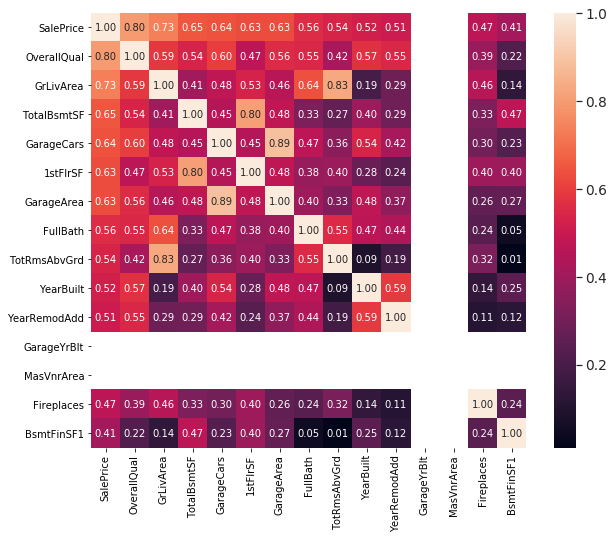

In [0]:
cols = corrmat.nlargest(15, "SalePrice")["SalePrice"].index
values = corrmat.nlargest(15, "SalePrice")["SalePrice"].values
high_corrmat = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
high_heatmap = sns.heatmap(high_corrmat, cbar=True, annot=True, fmt=".2f",
                          annot_kws={"size": 10}, square=True,
                          yticklabels=cols.values, xticklabels=cols.values)
high_cor = pd.concat([pd.Series(cols), pd.Series(values)], keys=["index", "value"], axis=1)
print(high_cor)

* We can see now which data could be relevant
* Furthermore you can see that there is some missing data...

In [0]:
train.SalePrice = np.log1p(train.SalePrice)

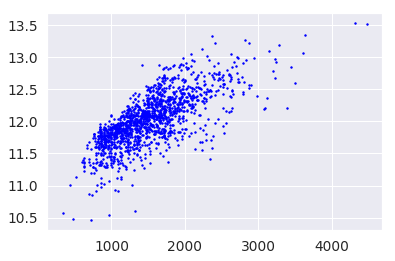

In [0]:
plt.scatter(train.GrLivArea, train.SalePrice, marker="o", c="blue", s=2)

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
y_sample = sample.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [0]:
# find the missing data
total_na = all_data.isnull().sum()
total_na = total_na.drop(total_na[total_na == 0].index).sort_values(ascending=False)
missing = pd.DataFrame({"Total Missing data": total_na})
missing.head(20)

,Total Missing data
PoolQC,2908
MiscFeature,2812
Alley,2719
Fence,2346
FireplaceQu,1420
LotFrontage,486
GarageQual,159
GarageCond,159
GarageFinish,159
GarageYrBlt,159


So fill in the missing gaps of the categories...

In [0]:
# handel missing values for features where median/mean or most common value does not
# make sense

# Alley: NA for Alley means "no alley access"
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("NoAl")

# BedroomAbvGr: NA for Bedrooms above ground means 0 Bedrooms
all_data.loc[:, "BedroomAbvGr"] = all_data.loc[:, "BedroomAbvGr"].fillna(0)

# BsmtXXX: NA for basement features means there is "no basement"
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("NoBa")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("NoBa")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("NoBa")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("NoBa")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("NoBa")

# Electrical: NA means no electricity
# Electrical: Should be dropped
#train = train.drop(train.loc[train.Electrical.isnull()].index)
all_data.loc[:, "Electrical"] = all_data.loc[:, "Electrical"].fillna("NoEL")

# Fence: NA means "no fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("NoFe")

# FireplaceQu: data description says NA means "no fireplace"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("NoFi")

# GarageType etc: data description says NA for garage features is "no garage"
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("NoGa")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("NoGa")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("NoGa")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("NoGa")
# use for GarageYrBlt the average
#train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
#train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)

#
# LotFrontage : NA most likely means no lot frontage
# to much data missing, try mean()
#train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
#

# MasVnrType: NA means no veneer
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)

# MiscFeature: NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("NoFe")
#train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)

# PoolQC: NA means "no pool"
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("NoPo")
#train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)

In [0]:
#Some numerical features are actually really categories
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr",
                                   5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug",
                                   9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"},
                       
                      })
# all_data.MSSubClass = all_data.MSSubClass.apply(str)
all_data.OverallCond = all_data.OverallCond.astype(str)
# all_data.MoSold = all_data.MoSold.astype(str)
all_data.YrSold = all_data.YrSold.astype(str)

In [0]:
# encode some categorical features as ordered numbers when there is information in
# the order
all_data = all_data.replace({#"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond": {"NoBa": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4,
                                   "Ex": 5},
                       "BsmtExposure": {"NoBa": 0, "Mn": 1, "Av": 2, "Gd": 3},
                       "BsmtFinType1" : {"NoBa" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3,
                                        "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"NoBa" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3,
                                        "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"NoBa" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4,
                                    "Ex" : 5},
                       
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       # try both
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       
                       "GarageCond" : {"NoGa" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"NoGa" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       # try both
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       # try both
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       
                       #"PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       
                       "PoolQC" : {"NoPo" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       
                       #"Street" : {"Grvl" : 1, "Pave" : 2},
                       # try both
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                            })

In [0]:
# differentiate numerical and categorical features
cat_features = all_data.select_dtypes(include=["object"]).columns
num_features = all_data.select_dtypes(exclude=["object"]).columns
#num_features = num_features.drop("SalePrice")
print("Numerical features: " + str(len(num_features)))
print("Categorical features: " + str(len(cat_features)))
all_data_num = all_data[num_features]
all_data_cat = all_data[cat_features]

Numerical features: 46
Categorical features: 33


In [0]:
print("NAs for numerical features in train : " + str(all_data_num.isnull().values.sum()))
all_data_num = all_data_num.fillna(all_data_num.mean())
print("Remaining NAs for numerical features in train : " + str(all_data_num.isnull().values.sum()))

NAs for numerical features in train : 660
Remaining NAs for numerical features in train : 0


In [0]:
# log transform of the skewed numerical features to lessen impact the outliers
skewness = all_data_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_data_num[skewed_features] = np.log1p(all_data_num[skewed_features])

37 skewed numerical features to log transform


In [0]:
# create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(all_data_cat.isnull().values.sum()))
all_data_cat = pd.get_dummies(all_data_cat)
print("Remaining NAs for categorical features in train : " + str(all_data_cat.isnull().values.sum()))

NAs for categorical features in train : 7
Remaining NAs for categorical features in train : 0


In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 285)


In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [0]:
# join numerical and categorical features
all_data = pd.concat([all_data_num, all_data_cat], axis=1)
print("New number of features : " + str(all_data.shape[1]))
train = all_data[:ntrain]
test = all_data[ntrain:]
print(len(test))
# # Partition the dataset in train + validation sets
# X_train, X_test, y_train, y_test = train_test_split(train.values, y_train, test_size = 0.3, random_state = 0)
# print("X_train : " + str(X_train.shape))
# print("X_test : " + str(X_test.shape))
# print("y_train : " + str(y_train.shape))
# print("y_test : " + str(y_test.shape))
print(len(train.values))
print(len(y_train))

New number of features : 285
1459
1458
1458


In [0]:
# stdSc = StandardScaler()
# train.values.loc[:, num_features] = stdSc.fit_transform(train.values.loc[:, num_features])
# X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

In [0]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring=scorer, cv=10))
    return(rmse)

In [0]:
l1 = [0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100]
l2 = np.arange(100) + 1
l3 = l2 * 0.1
l4 = l2 * 0.01
l5 = l2 * 0.001
l6 = l2 * 0.0001
l7 = l2 * 0.00001
l8 = l2 * 0.000001
print(l3)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10. ]


In [0]:
l2_1 = np.arange(1000) + 1
l3_1 = l2_1 * 0.1
l4_1 = l2_1 * 0.01


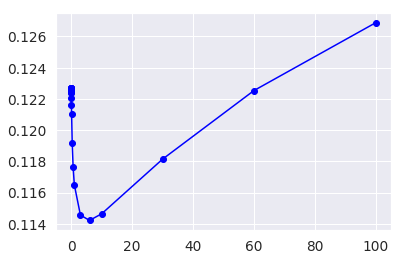

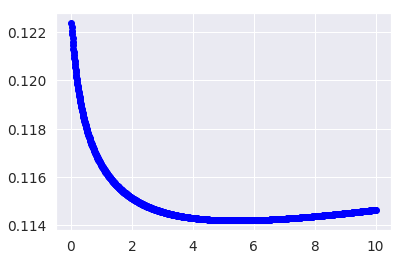

Best alpha =  5.44
Ridge Regression RMSE on Training Set:  0.11420564893745748


In [0]:
alphalist = []
rmselist = []
for i in l1:
    ridge = RidgeCV(alphas=[i])
    ridge.fit(train.values, y_train)
    alpha = ridge.alpha_
    alphalist.append(alpha)
    rmselist.append(rmse_cv_train(ridge).mean())
    
plt.plot(alphalist, rmselist, marker="o", c="blue")
plt.show()

rmselist2=[]
alphalist2=[]
minrmse = 0.5
minalpha = 0
for i in l4_1:
    ridge = RidgeCV(alphas=[i])
    ridge.fit(train.values, y_train)
    alpha = ridge.alpha_
    alphalist2.append(alpha)
    rmse = rmse_cv_train(ridge).mean()
    rmselist2.append(rmse)
    if rmse < minrmse:
        minrmse = rmse
        minalpha = alpha
    
plt.plot(alphalist2, rmselist2, marker="o", c="blue")
plt.show()

print("Best alpha = ", minalpha)
print("Ridge Regression RMSE on Training Set: ", minrmse)

In [0]:
lasso = LassoCV(alphas = [0.00031], max_iter=50000, cv=10)
lasso.fit(train.values, y_train)
# alpha = lasso.alpha_
# print("Best alpha: ", alpha)
print("Lasso RMSE on Training set: ", rmse_cv_train(lasso).mean())

Lasso RMSE on Training set:  0.11245023542704272


Alpha: 1e-05 RMSE: 0.12004737711911453
Alpha: 3e-05 RMSE: 0.11788983251983567
Alpha: 6e-05 RMSE: 0.11608221172362539
Alpha: 0.0001 RMSE: 0.1143543152658448
Alpha: 0.0003 RMSE: 0.11238672159836142
Alpha: 0.0006 RMSE: 0.11369060231097645
Alpha: 0.001 RMSE: 0.11652922335758217
Alpha: 0.003 RMSE: 0.1315036276169469
Alpha: 0.006 RMSE: 0.14112209276116602
Alpha: 0.01 RMSE: 0.14720918108315223


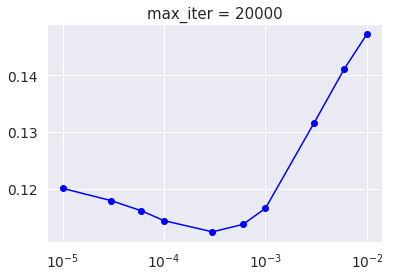

In [0]:
rmselist = []
j = 20000
for i in [0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01]:
    lasso = LassoCV(alphas=[i], max_iter=j, cv=10)
    lasso.fit(train.values, y_train)
    rmse = rmse_cv_train(lasso).mean()
    rmselist.append(rmse)
    print("Alpha: " + str(i) + " RMSE: " + str(rmse))

plt.plot([0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01], rmselist, marker="o", c="blue")
plt.title("max_iter = " + str(j))
plt.xscale("log")
plt.show()

In [0]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train.values, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train.values, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train.values, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
y_train_ela = elasticNet.predict(train.values)

Best l1_ratio : 0.9
Best alpha : 0.0003
Try again for more precision with l1_ratio centered around 0.9
Best l1_ratio : 0.9
Best alpha : 0.0003
Now try again for more precision on alpha, with l1_ratio fixed at 0.9 and alpha centered around 0.0003
Best l1_ratio : 0.9
Best alpha : 0.000285
ElasticNet RMSE on Training set : 0.11250657174224128


In [0]:
krr = KernelRidge(alpha=[100, 300, 500, 550, 600, 650, 700, 900, 1000], kernel="polynomial", degree=2, coef0=5)
krr.fit(train.values, y_train)
print("KRR RMSE on Training Set: ", rmse_cv_train(krr).mean())

KRR RMSE on Training Set:  0.1166157940835936


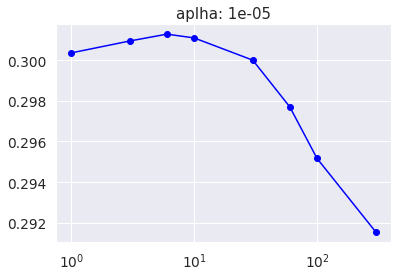

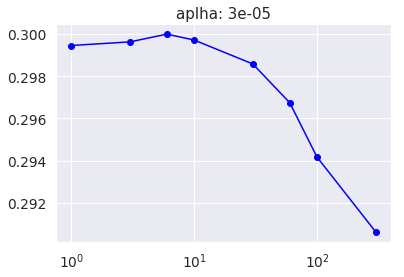

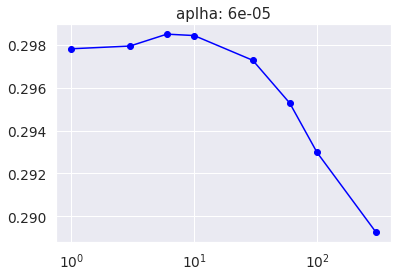

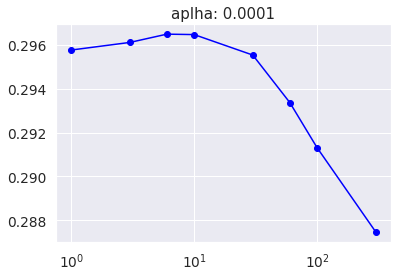

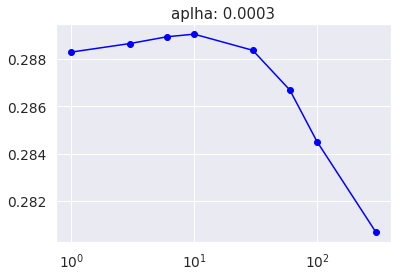

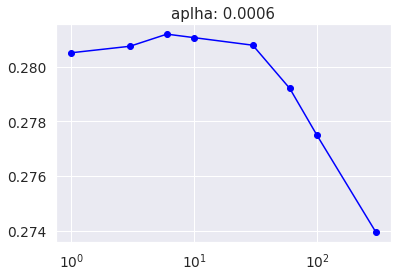

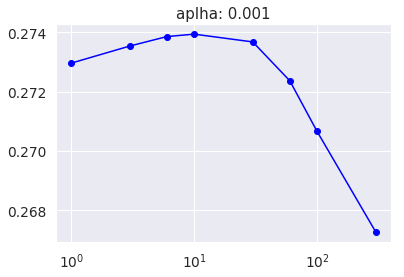

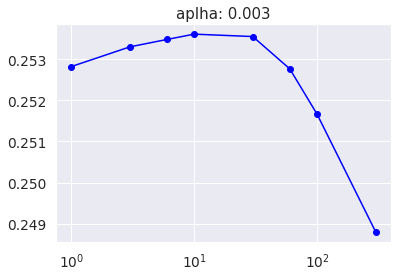

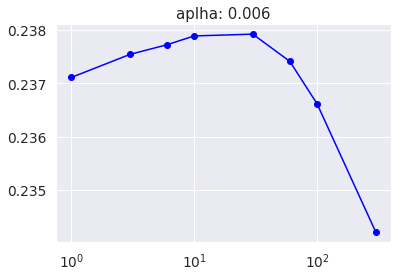

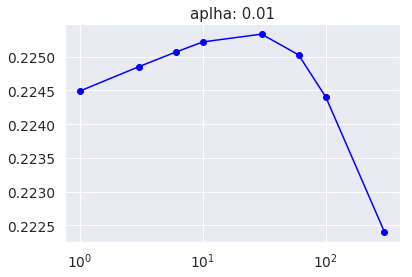

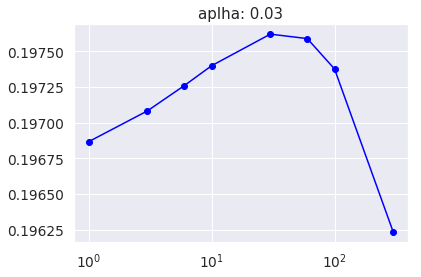

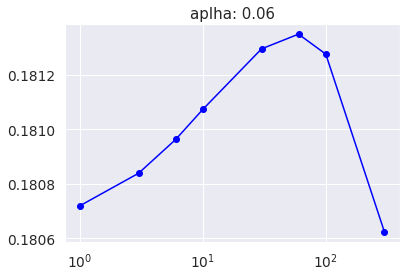

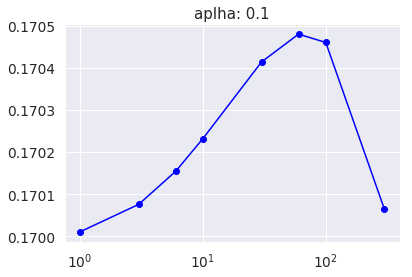

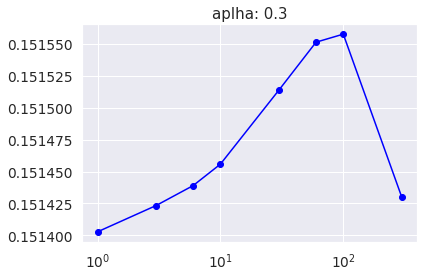

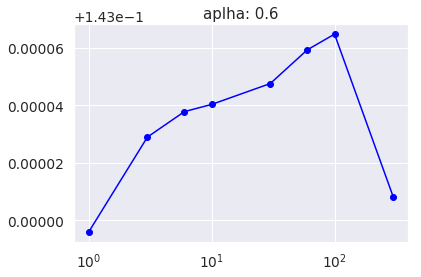

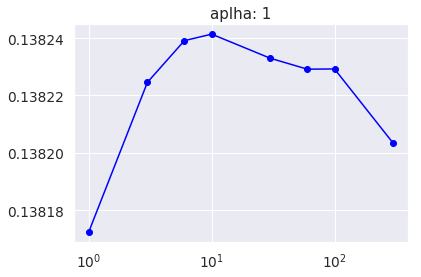

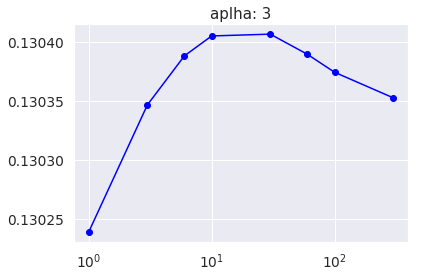

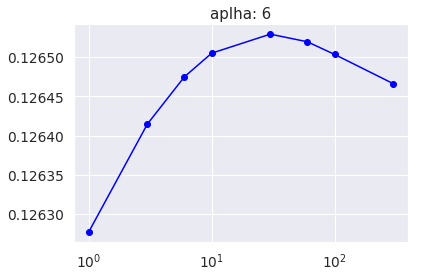

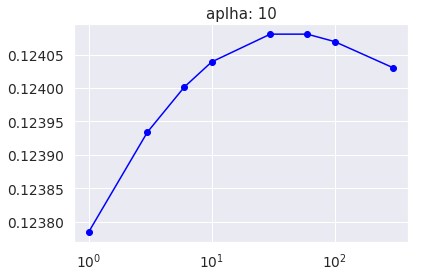

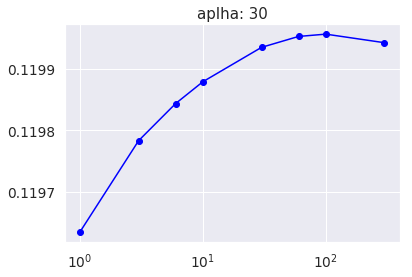

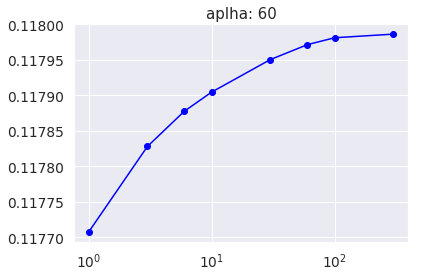

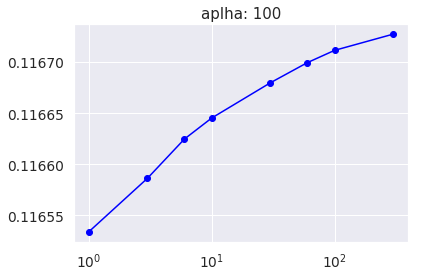

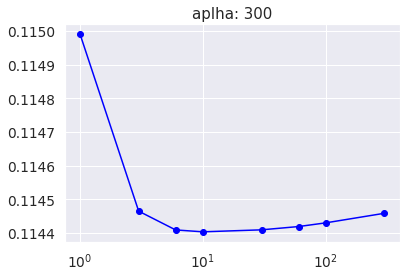

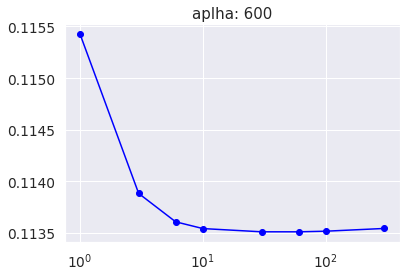

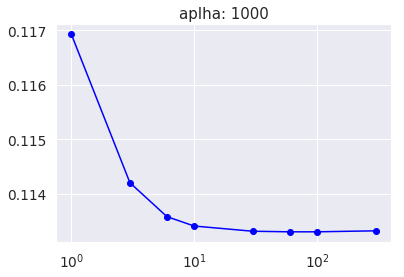

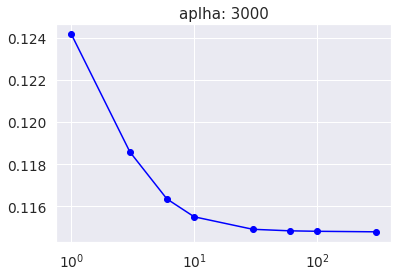

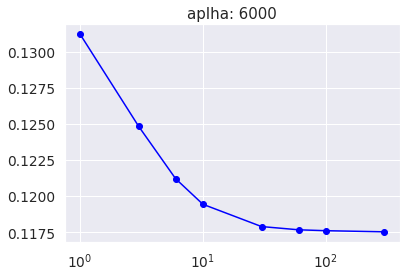

Alpha: 1000
coef0: 100
KRR RMSE on Training Set:  0.11330269590631134


In [0]:
minrmse = 0.5
alpha = 0
coef0 = 0
for i in [0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3,
          0.6, 1, 3, 6, 10, 30, 60, 100, 300, 600, 1000, 3000, 6000]:
    rmselist = []
    for j in [1, 3, 6, 10, 30, 60, 100, 300]:
        krr = KernelRidge(alpha=[i], kernel="polynomial", degree=2, coef0=j)
        krr.fit(train.values, y_train)
        rmse = rmse_cv_train(krr).mean()
        rmselist.append(rmse)
        if rmse < minrmse:
            minrmse = rmse
            alpha = i
            coef0 = j
        
    plt.plot([1, 3, 6, 10, 30, 60, 100, 300], rmselist, marker="o", c="blue")
    plt.title("aplha: " + str(i))
    plt.xscale("log")
    plt.show()

print("Alpha: " + str(alpha))
print("coef0: " + str(coef0))
print("KRR RMSE on Training Set: ", minrmse)

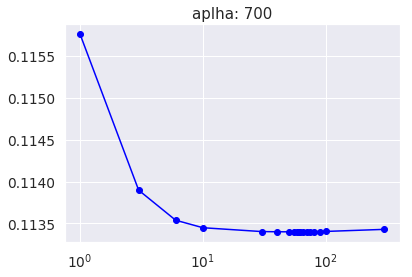

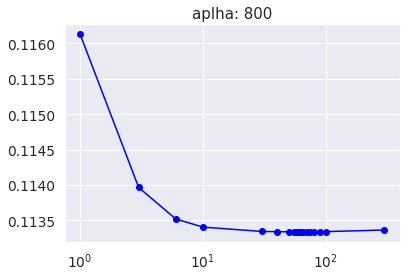

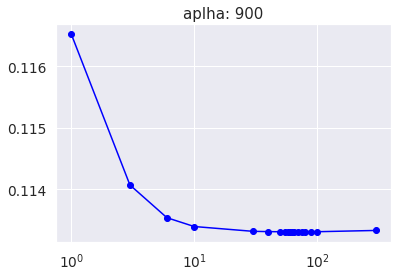

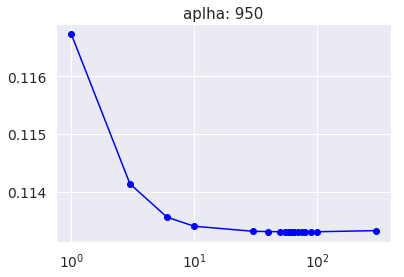

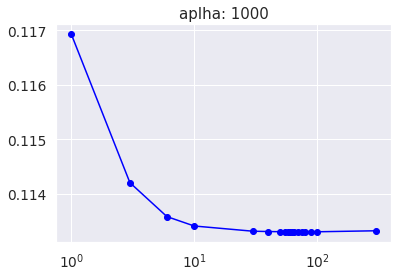

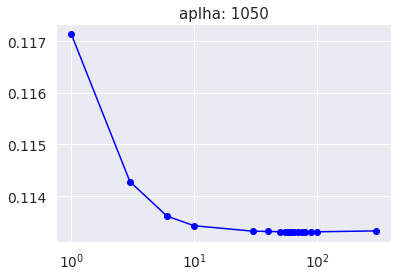

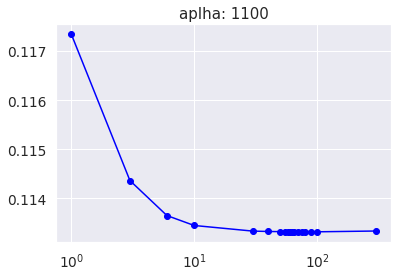

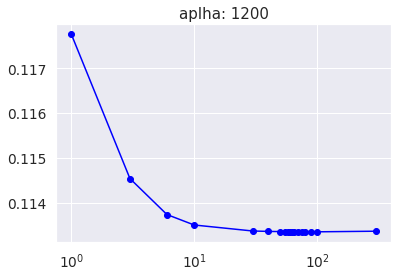

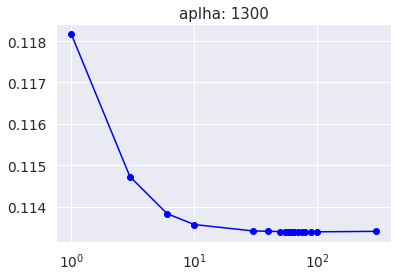

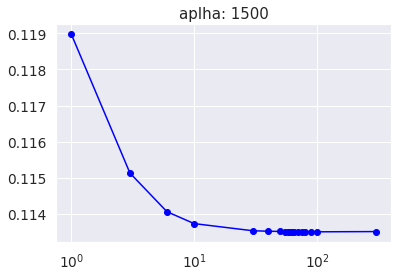

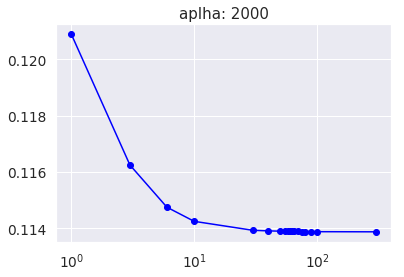

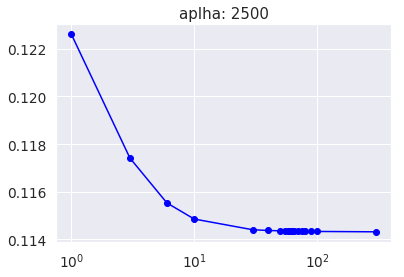

Alpha: 950
coef0: 75
KRR RMSE on Training Set:  0.11330124434919224


In [0]:
minrmse = 0.5
alpha = 0
coef0 = 0
for i in [700, 800, 900, 950, 1000, 1050, 1100, 1200, 1300, 1500, 2000, 2500]:
    rmselist = []
    for j in [1, 3, 6, 10, 30, 40, 50, 55, 58, 60, 62, 65, 70, 75, 80, 90, 100, 300]:
        krr = KernelRidge(alpha=[i], kernel="polynomial", degree=2, coef0=j)
        krr.fit(train.values, y_train)
        rmse = rmse_cv_train(krr).mean()
        rmselist.append(rmse)
        if rmse < minrmse:
            minrmse = rmse
            alpha = i
            coef0 = j
        
    plt.plot([1, 3, 6, 10, 30, 40, 50, 55, 58, 60, 62, 65, 70, 75, 80, 90, 100, 300], rmselist, marker="o", c="blue")
    plt.title("aplha: " + str(i))
    plt.xscale("log")
    plt.show()

print("Alpha: " + str(alpha))
print("coef0: " + str(coef0))
print("KRR RMSE on Training Set: ", minrmse)

In [0]:
minrmse = 0.5
max_depth = 0
learning_rate = 0
n_estimators = 0

for i in [1, 2, 3, 4, 5, 6]:
    for j in [0.01, 0.03, 0.06, 0.1, 0.3]:
        for k in [10, 30, 60, 100, 300, 600, 1000, 3000, 6000]:
            GBoost = GradientBoostingRegressor(n_estimators=k, learning_rate=j, max_depth=i, max_features="sqrt", min_samples_leaf=15, min_samples_split=10,
                                              loss="huber", random_state=5)
            GBoost.fit(train.values, y_train)
            rmse = rmse_cv_train(GBoost).mean()
            if rmse < minrmse:
                minrmse = rmse
                max_depth = i
                learning_rate = j
                n_estimators = k

print("n_estimators: " + str(n_estimators) + " learning_rate: " + str(learning_rate) + " max_depth: " + str(max_depth))
print("XGB RMSE on Training set: ", minrmse)

In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones of ther original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # train all cloned models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    # predictions for cloned models
    def predict(self, X):
        l = []
        for model in self.models_:
            p = model.predict(X)
            print(p)
            l.append(p)
        print(l)
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [0]:
averaged_models = AveragingModels(models = (lasso, elasticNet, KRR, GBoost))

print("Averaged Models RMSE on Training set :", rmse_cv_train(averaged_models).mean())


In [0]:
# averaged2 = AveragingModels(models = (lasso, KRR, GBoost))
# print("Averaged Models RMSE on Training set: ", rmse_cv_train(averaged2).mean())
# averaged3 = AveragingModels(models = (elasticNet, KRR, GBoost))
# print("Averaged Models RMSE on Training set: ", rmse_cv_train(averaged3).mean())
# averaged4 = AveragingModels(models = (KRR, GBoost))
# print("Averaged Models RMSE on Training set: ", rmse_cv_train(averaged4).mean())
averaged5 = AveragingModels(models = (lasso, GBoost))
print("Averaged Models RMSE on Training set: ", rmse_cv_train(averaged5).mean())

In [0]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [0]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
averaged_pred = np.expm1(averaged_models.predict(test.values))
print(rmse(y_train, averaged_train_pred))

In [0]:
sub = pd.DataFrame()
sub["Id"] = test_ID
sub["SalePrice"] = averaged_pred
sub.to_csv("submission2.csv", index=False)

In [0]:
averaged5.fit(train.values, y_train)
averaged5_train_pred = averaged5.predict(train.values)
averaged5_pred = np.expm1(averaged5.predict(test.values))
print(rmse(y_train, averaged5_train_pred))


In [0]:
sub = pd.DataFrame()
sub["Id"] = test_ID
sub["SalePrice"] = averaged5_pred
sub.to_csv("submission.csv", index=False)